In [1]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.decomposition import PCA
from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor

from sklearn.linear_model import Ridge

from other_functions import *

## Dimension reduction and clustering of the CTRP-L1000 dataset

In [2]:
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                       sep=',',header=0,index_col=[0])
signatures=pd.read_table('../results/CTRP/signatures_merged_lm.csv',
                         sep=',',header=0,index_col=[0])

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  from ipykernel import kernelapp as app
/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: read_table is deprecated, use read_csv instead.


Let's do first a PCA and color the points based on the matched cell viability.

In [4]:
#let's do first a PCA
model=PCA(2,random_state=19890904)
signatures_pca=pd.DataFrame(model.fit_transform(signatures),
                            index=signatures.index)
evr1,evr2=model.explained_variance_ratio_.round(3).astype(str)
signatures_pca.columns=['PC1\nexplained variance ratio: '+evr1,
                      'PC2\nexplained variance ratio: '+evr2]
#signatures_pca.to_csv('../results/model/dimension_reduction/pca.csv',
#                      sep=',')

Spearman Rho with X: SpearmanrResult(correlation=-0.2781532023940811, pvalue=0.0)
Spearman Rho with Y: SpearmanrResult(correlation=-0.17933387221611252, pvalue=2.787893031404833e-135)


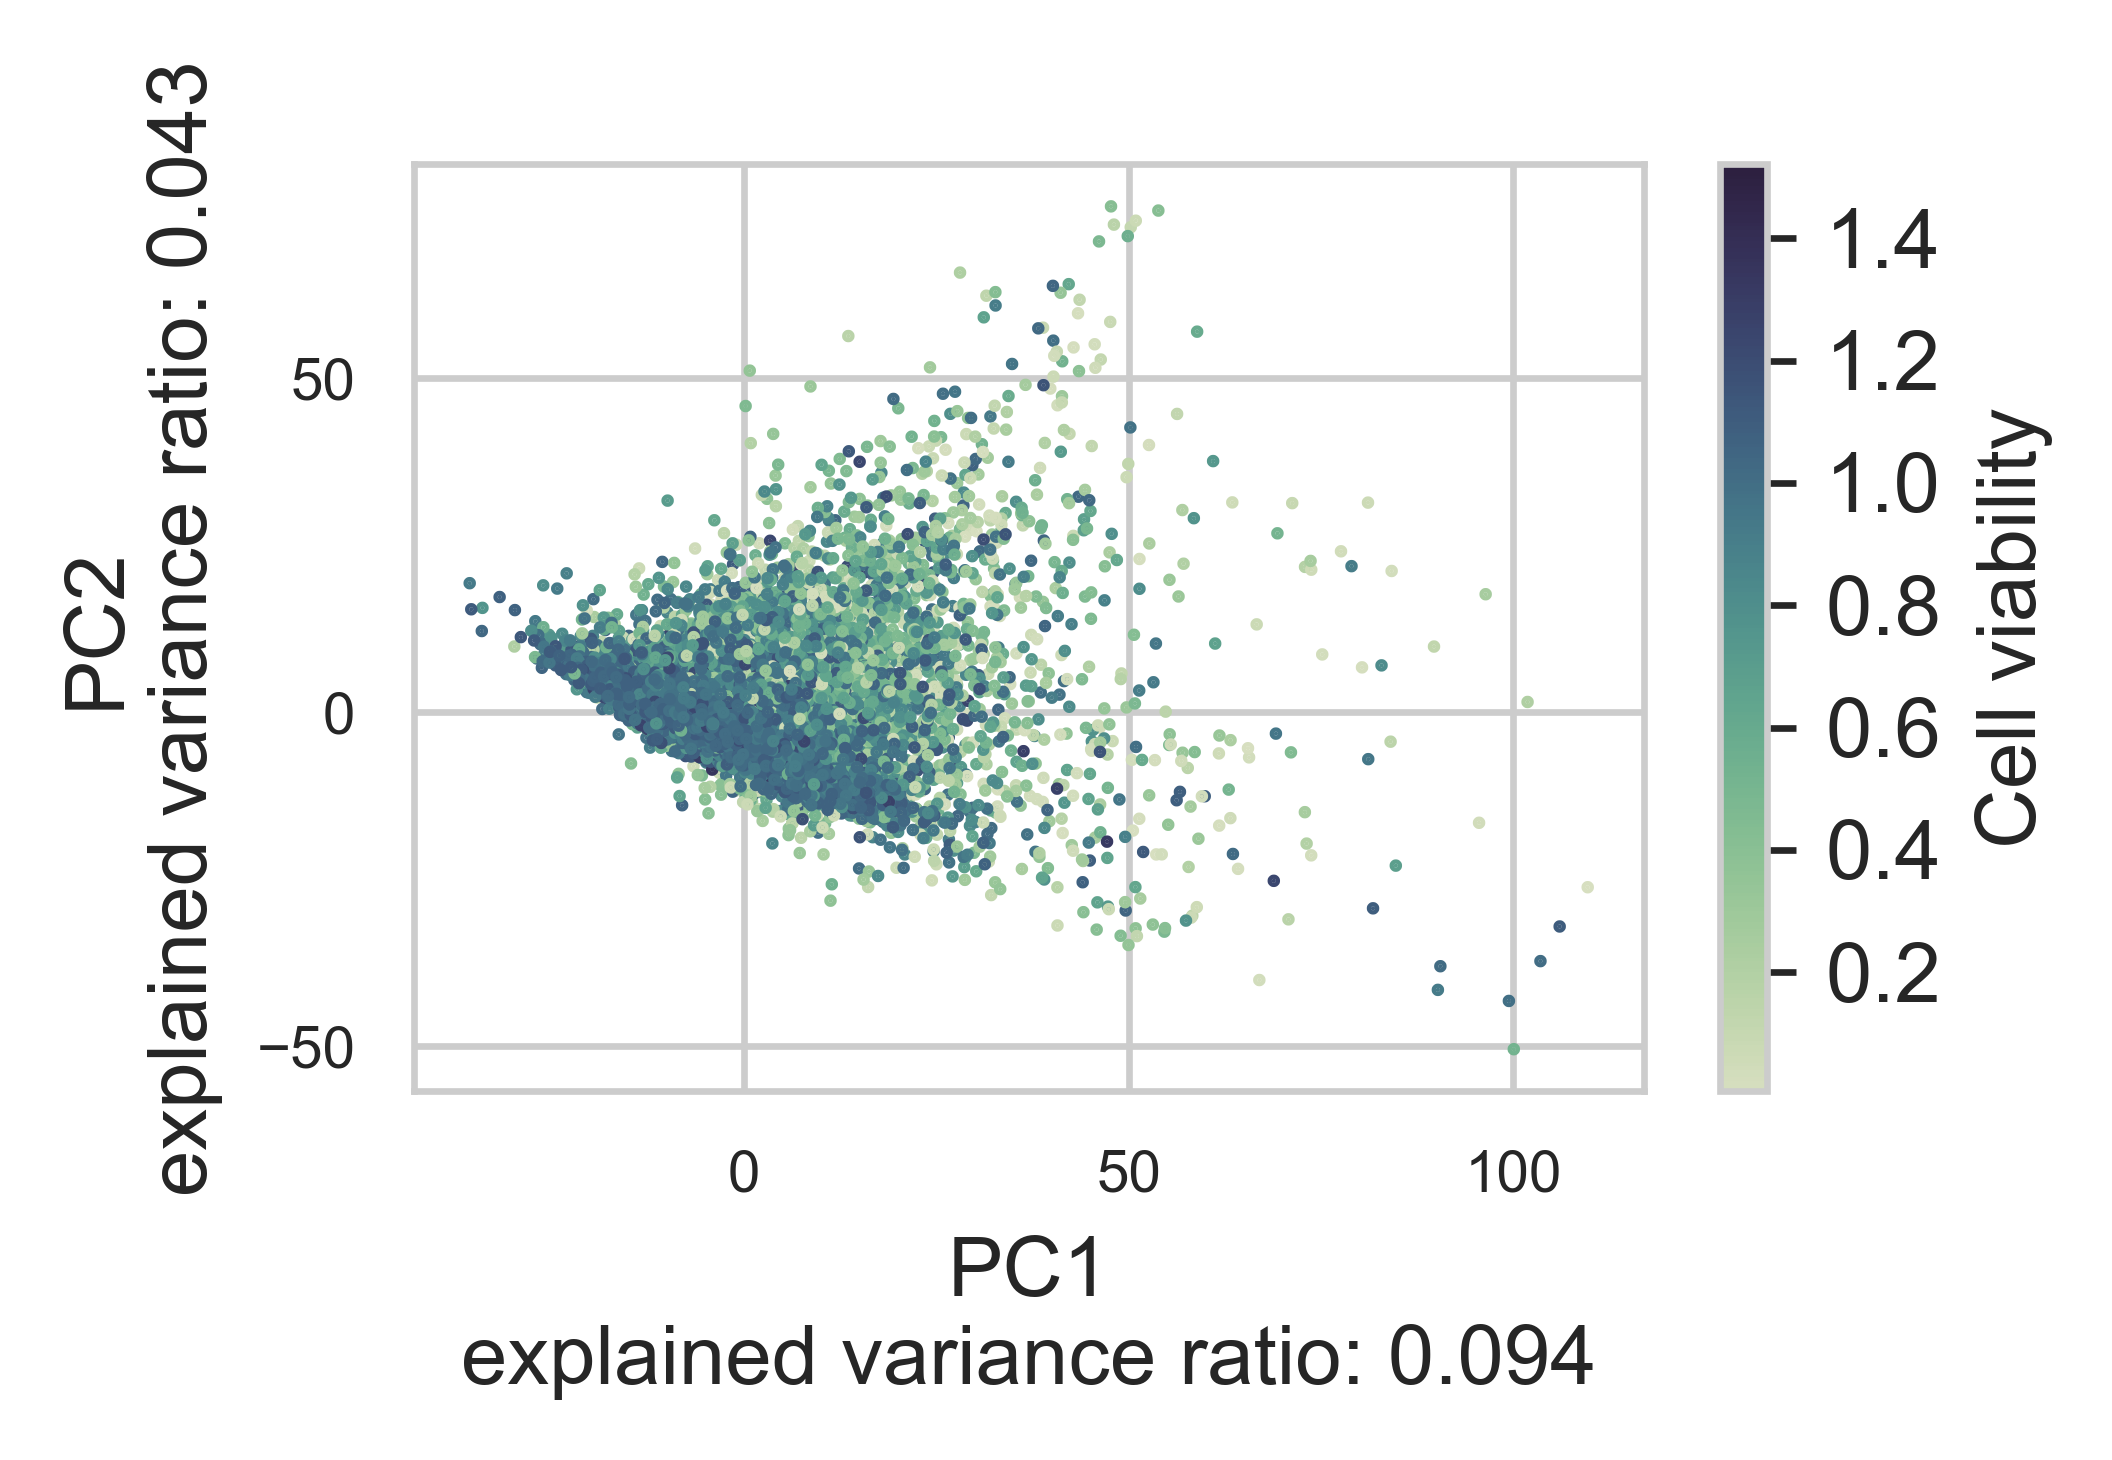

In [5]:
#and the plotting
make_dim_reduc_plot(signatures_pca,sig_info)

Association between PC1 (PC2) and cell viability suggest that viability is an important factor behind perturbation gene expression signatures. We will build a linear model to predict cell viaiblity from gene expression.
## Cell viability predictions

In [6]:
#just reading the data
SIGNATURES={}
SIG_INFO={}
SIGNATURES['CTRP']=pd.read_table('../results/CTRP/signatures_merged_lm.csv',
                            sep=',',header=0,index_col=[0])
SIGNATURES['Achilles']=pd.read_table('../results/Achilles/signatures_merged_lm.csv',
                            sep=',',header=0,index_col=[0])
SIG_INFO['CTRP']=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                            sep=',',header=0,index_col=[0])
SIG_INFO['Achilles']=pd.read_table('../results/Achilles/sig_info_merged_lm.csv',
                            sep=',',header=0,index_col=[0])

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: read_table is deprecated, use read_csv instead.
/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: read_table is deprecated, use read_csv instead.


In [7]:
def make_prediction_with_cv(tr='CTRP',cv='CTRP',
                        tr_time='24 h',cv_time='24 h',s=0):
    """makes prediction for CTRP / Achilles cell viability / shRNA abundance
    based on L1000 signatures. tr and cv are training and cv datasets, while 
    tr_time and cv_time are the perturbattion times to be used. Uses signatures
    and sig_info global variables.""" 
    #reading data and make tr/cv split
    features=SIGNATURES[cv].copy()
    response=SIG_INFO[cv].copy()
    if cv_time!='all':
        fil=response['pert_itime']==cv_time
    else:
        fil=response['pert_itime']!=cv_time
    features_cv=features[fil]
    response_cv=response[fil]
    np.random.seed(s)
    cv_index=list(np.random.choice(features_cv.index,int(len(features_cv.index)/2),False))
    if tr==cv:
        if tr_time!='all':
            fil=response['pert_itime']==tr_time
        else:
            fil=response['pert_itime']!=tr_time
        features_tr=features[fil]
        response_tr=response[fil]
        tr_index=list(set(features_tr.index)-set(cv_index))
    else:
        features=SIGNATURES[tr].copy()
        features=features.loc[:,features_cv.columns]
        response=SIG_INFO[tr].copy()
        if tr_time!='all':
            fil=response['pert_itime']==tr_time
        else:
            fil=response['pert_itime']!=tr_time
        features_tr=features[fil]
        response_tr=response[fil]
        tr_index=list(set(features_tr.index)-set(cv_index))
    features_tr=features_tr.loc[tr_index,:]
    response_tr=response_tr.loc[tr_index,:]
    features_cv=features_cv.loc[cv_index,:]
    response_cv=response_cv.loc[cv_index,:]
    
    #setting response variable (variable to fit model on / to predict)
    if tr=='CTRP':
        tr_variable='cpd_avg_pv'
    if tr=='Achilles':
        tr_variable='shRNA_abundance'
    if cv=='CTRP':
        cv_variable='cpd_avg_pv'
    if cv=='Achilles':
        cv_variable='shRNA_abundance'
    
    #train and evaluate model
    model=Ridge()
    model.fit(features_tr,response_tr[tr_variable])
    y_pr=model.predict(features_cv)
    y=response_cv[cv_variable].values
    r,p=pcor(y_pr,y)
    return r,p

In [8]:
# just a quick example for model evaulation
for train in ['CTRP','Achilles']:
    for test in ['CTRP','Achilles']:
        r,p=make_prediction_with_cv(tr=train,cv=test,tr_time='all',cv_time='all',s=0)
        print('Model trained on %s and tested on %s, Pearson r: %f' % (train,test,r))

Model trained on CTRP and tested on CTRP, Pearson r: 0.595645
Model trained on CTRP and tested on Achilles, Pearson r: 0.192632
Model trained on Achilles and tested on CTRP, Pearson r: 0.344564
Model trained on Achilles and tested on Achilles, Pearson r: 0.502767


In [31]:
#evaulation with 20 random subsampling validation (takes some time)
results=pd.DataFrame(columns=['Train data','CV data','r','p','s'])
n=0
for tr in [('CTRP','all'),('Achilles','all')]:
    for cv in [('CTRP','all'),('Achilles','all')]:
        print('Training:',tr,'Test:',cv)
        for s in range(20): #seeds
            r,p=make_prediction_with_cv(tr[0],cv[0],tr[1],cv[1],s)
            temp=pd.DataFrame(index=[n],columns=['Train data','CV data','r','p','s'])
            temp.loc[n,:]=[tr[0],cv[0],r,p,s]
            results=pd.concat([results,temp])
            n+=1
results.to_csv('../results/model/cv/achilles_ctrp_all_prediction.csv',sep=',')

Training: ('CTRP', 'all') Test: ('CTRP', 'all')
Training: ('CTRP', 'all') Test: ('Achilles', 'all')
Training: ('Achilles', 'all') Test: ('CTRP', 'all')
Training: ('Achilles', 'all') Test: ('Achilles', 'all')


In [33]:
#evaulation using signatures generated after different perturbation time
results=pd.DataFrame(columns=['Train data','CV data','Train time','CV time','r','p','s'])
n=0
for tr in [('CTRP','3 h'),('CTRP','6 h'),('CTRP','24 h'),
           ('Achilles','96 h'),('Achilles','120 h'),('Achilles','144 h')]:
    for cv in [('CTRP','3 h'),('CTRP','6 h'),('CTRP','24 h'),
               ('Achilles','96 h'),('Achilles','120 h'),('Achilles','144 h')]:
            print('Training:',tr,'Test:',cv)
            for s in range(20): #seeds
                r,p=make_prediction_with_cv(tr[0],cv[0],tr[1],cv[1],s)
                temp=pd.DataFrame(index=[n],columns=['Train data','CV data','Train time','CV time','r','p','s'])
                temp.loc[n,:]=[tr[0],cv[0],tr[1],cv[1],r,p,s]
                results=pd.concat([results,temp])
                n+=1
    results.to_csv('../results/model/cv/achilles_ctrp_time_prediction.csv',sep=',')

Training: ('CTRP', '3 h') Test: ('CTRP', '3 h')
Training: ('CTRP', '3 h') Test: ('CTRP', '6 h')
Training: ('CTRP', '3 h') Test: ('CTRP', '24 h')
Training: ('CTRP', '3 h') Test: ('Achilles', '96 h')
Training: ('CTRP', '3 h') Test: ('Achilles', '120 h')
Training: ('CTRP', '3 h') Test: ('Achilles', '144 h')
Training: ('CTRP', '6 h') Test: ('CTRP', '3 h')
Training: ('CTRP', '6 h') Test: ('CTRP', '6 h')
Training: ('CTRP', '6 h') Test: ('CTRP', '24 h')
Training: ('CTRP', '6 h') Test: ('Achilles', '96 h')
Training: ('CTRP', '6 h') Test: ('Achilles', '120 h')
Training: ('CTRP', '6 h') Test: ('Achilles', '144 h')
Training: ('CTRP', '24 h') Test: ('CTRP', '3 h')
Training: ('CTRP', '24 h') Test: ('CTRP', '6 h')
Training: ('CTRP', '24 h') Test: ('CTRP', '24 h')
Training: ('CTRP', '24 h') Test: ('Achilles', '96 h')
Training: ('CTRP', '24 h') Test: ('Achilles', '120 h')
Training: ('CTRP', '24 h') Test: ('Achilles', '144 h')
Training: ('Achilles', '96 h') Test: ('CTRP', '3 h')
Training: ('Achilles', 

Our linear models used the perturbation gene expression signatures to predict cell viability. The calssical way to predict cell viaiblity (either after drug or shRNA treatment) is using baseline molecular features of cell lines and some features of the drugs / shRNAs. As we have low number of cell lines (<50) we used simply an indicator vector (1 if cell line is perturbed, 0 otherwise) as cell line feature. For drugs classical used features are nominal target, chemical fingerprint etc.. However as we do not have corresponding features for shRNAs, we used indicattor vectors also for as drug features. For drug perturbation, we also used log10 drug concentration as feature. The comparison of our models against these classical methods aims only to have some insight how a classical drug sensitivity prediction model would perform.

In [47]:
def make_prediction_classical(data='CTRP',time='24 h',s=0):
    response=SIG_INFO[data].copy()
    fil=response['pert_itime']==time
    response=response[fil]
    np.random.seed(s)
    cv_index=list(np.random.choice(response.index,int(len(response.index)/2),False))
    #creates indicator matrix
    cell_lines=list(set(response['cell_id']))
    cell_features=pd.DataFrame(np.identity(len(cell_lines),int),
                               index=cell_lines,columns=cell_lines)
    perts=list(set(response['pert_id']))
    pert_features=pd.DataFrame(np.identity(len(perts),int),
                               index=perts,columns=perts)
    cell_features=cell_features.loc[response['cell_id'].values]
    cell_features.index=response.index
    pert_features=pert_features.loc[response['pert_id'].values]
    pert_features.index=response.index
    features=pd.concat([cell_features,pert_features],1)
    if data=='CTRP':
        features['log10_cpd_conc_umol']=response['log10_cpd_conc_umol']
    tr_index=list(set(response.index)-set(cv_index))
    features_tr=features.loc[tr_index,:]
    response_tr=response.loc[tr_index,:]
    features_cv=features.loc[cv_index,:]
    response_cv=response.loc[cv_index,:]
    
    #setting response variable (variable to fit model on / to predict)
    if data=='CTRP':
        resp_variable='cpd_avg_pv'
    else:
        resp_variable='shRNA_abundance'
    
    
    #train and evaluate model
    model=Ridge()
    model.fit(features_tr,response_tr[resp_variable])
    y_pr=model.predict(features_cv)
    y=response_cv[resp_variable].values
    r,p=pcor(y_pr,y)
    return r,p

In [55]:
#make these classical predictions, only within dataset setting
results=pd.DataFrame(columns=['Train data','CV data','Train time','CV time','r','p','s'])
n=0
for tr in [('CTRP','3 h'),('CTRP','6 h'),('CTRP','24 h'),
           ('Achilles','96 h'),('Achilles','120 h'),('Achilles','144 h')]:
    print(tr)
    for s in range(20):
        r,p=make_prediction_classical(tr[0],tr[1],s)
        temp=pd.DataFrame(index=[n],columns=['Train data','CV data','Train time','CV time','r','p','s'])
        temp.loc[n,:]=[tr[0],tr[0],tr[1],tr[1],r,p,s]
        results=pd.concat([results,temp])
        n+=1
results.to_csv('../results/model/cv/achilles_ctrp_classical_prediction.csv',sep=',')

('CTRP', '3 h')
('CTRP', '6 h')
('CTRP', '24 h')
('Achilles', '96 h')
('Achilles', '120 h')
('Achilles', '144 h')


We are evaulating these predictions more detailed in the notebook cell_death_8_figures.

Now we will save the two best models (Achilles-L1000-96h and CTRP-L1000-24h) for further use.

In [34]:
#achilles model
signatures=SIGNATURES['Achilles'].copy()
sig_info=SIG_INFO['Achilles'].copy()
fil=sig_info['pert_itime']=='96 h'
sig_info=sig_info[fil]
signatures=signatures[fil]
model=Ridge()
model.fit(signatures,sig_info['shRNA_abundance'])
fout=open('../results/model/final_models/achilles.pkl','wb') #we use the binary file later
pickle.dump(model,fout)
fout.close()
results=pd.DataFrame(index=signatures.columns.astype(int),columns=['pr_gene_symbol','coefficient'])
gene_info=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_gene_info.txt',sep='\t')
gene_info.index=gene_info['pr_gene_id'].astype(int)
gene_info=gene_info['pr_gene_symbol']
results['pr_gene_symbol']=gene_info[results.index].values
results['coefficient']=model.coef_
results.loc['INTERCEPT']=model.intercept_
results.to_csv('../results/model/final_models/achilles.csv',sep=',')

In [16]:
#ctrp model
signatures=SIGNATURES['CTRP'].copy()
sig_info=SIG_INFO['CTRP'].copy()
fil=sig_info['pert_itime']=='24 h'
sig_info=sig_info[fil]
signatures=signatures[fil]
model=Ridge()
model.fit(signatures,sig_info['cpd_avg_pv'])
fout=open('../results/model/final_models/ctrp.pkl','wb') #we use the binary file later
pickle.dump(model,fout)
fout.close()
results=pd.DataFrame(index=signatures.columns.astype(int),columns=['pr_gene_symbol','coefficient'])
gene_info=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_gene_info.txt',sep='\t')
gene_info.index=gene_info['pr_gene_id'].astype(int)
gene_info=gene_info['pr_gene_symbol']
results['pr_gene_symbol']=gene_info[results.index].values
results['coefficient']=model.coef_
results.loc['INTERCEPT']=model.intercept_
results.to_csv('../results/model/final_models/ctrp.csv',sep=',')

These models are well suited to predict cell viability from gene expression measured in LINCS-L1000. However to use them in gene expression measured by other platforms, missing genes and other problems can occure. To overcome these problems, we created 2 addtional models, Achilles-L1000-96h-single and CTRP-L1000-24h-single. These models are constructed by fitting a linear model between cell viability and gene expression for each gene separately, and using the coefficients of the top 100 (largest abs. coefficient) gene - viability associations (similar to PROGENy method by [Schubert et al. 2018 Nature Communications](https://www.nature.com/articles/s41467-017-02391-6)).

In [3]:
signatures=SIGNATURES['Achilles'].copy()
sig_info=SIG_INFO['Achilles'].copy()
fil=sig_info['pert_itime']=='96 h'
sig_info=sig_info[fil]
signatures=signatures[fil]
signatures['shRNA_abundance']=sig_info['shRNA_abundance']

In [4]:
import statsmodels.api as sm
model_results=pd.DataFrame(index=signatures.columns[:-1],columns=['p_val','coef'])

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
Y=signatures['shRNA_abundance']
for gene in signatures.columns[:-1]:
    X=signatures[gene]
    X=sm.add_constant(X)
    model = sm.OLS(Y,X)
    results=model.fit()
    model_results.loc[gene]=(results.pvalues[gene],results.params[gene])

In [59]:
gene_info=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_gene_info.txt',sep='\t')
gene_info.index=gene_info['pr_gene_id'].astype(str)
gene_info=gene_info['pr_gene_symbol']
model_results['coef_abs']=np.abs(model_results['coef'])
model_results['pr_gene_symbol']=gene_info[model_results.index]
model_results=model_results.sort_values(['p_val','coef_abs'],ascending=[True,False])

In [60]:
model_results.loc[model_results.index[100:],'coef']=0
model_results=model_results[['pr_gene_symbol','coef']]
model_results.to_csv('../results/model/final_models/achilles_single.csv')

In [14]:
# same for ctrp model
signatures=SIGNATURES['CTRP'].copy()
sig_info=SIG_INFO['CTRP'].copy()
fil=sig_info['pert_itime']=='24 h'
sig_info=sig_info[fil]
signatures=signatures[fil]
signatures['cpd_avg_pv']=sig_info['cpd_avg_pv']
model_results=pd.DataFrame(index=signatures.columns[:-1],columns=['p_val','coef'])
Y=signatures['cpd_avg_pv']
for gene in signatures.columns[:-1]:
    X=signatures[gene]
    X=sm.add_constant(X)
    model = sm.OLS(Y,X)
    results=model.fit()
    model_results.loc[gene]=(results.pvalues[gene],results.params[gene])
gene_info=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_gene_info.txt',sep='\t')
gene_info.index=gene_info['pr_gene_id'].astype(str)
gene_info=gene_info['pr_gene_symbol']
model_results['coef_abs']=np.abs(model_results['coef'])
model_results['pr_gene_symbol']=gene_info[model_results.index]
model_results=model_results.sort_values(['p_val','coef_abs'],ascending=[True,False])
model_results.loc[model_results.index[100:],'coef']=0
model_results=model_results[['pr_gene_symbol','coef']]
model_results.to_csv('../results/model/final_models/ctrp_single.csv')